# Détection de ventes anormales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.options.mode.chained_assignment = None

## Chargement des données

Source des données: https://www.kaggle.com/c/rossmann-store-sales/data

In [3]:
df = pd.read_csv("data/train.csv")
store = pd.read_csv("data/store.csv")

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
store.shape

(1115, 10)

In [8]:
print(df.shape)
df = pd.merge(df,store, on="Store", how= "left")
print(df.shape)

(1017209, 9)
(1017209, 18)


In [9]:
df.Date = pd.to_datetime(df.Date)

In [10]:
df.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

In [11]:
print("période de",df.Date.min(),"à",df.Date.max())

période de 2013-01-01 00:00:00 à 2015-07-31 00:00:00


## Exploration des données

Quels facteurs déterminent les déviations anormales des ventes ? Les valeurs anormales peuvent être à la fois très hautes ou très basses par rapport à leur valeur attendue. On va décomposer les Sales suivant certains facteurs (cycles, promos) afin d'en extraire plus facilement les valeurs aberrantes.

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


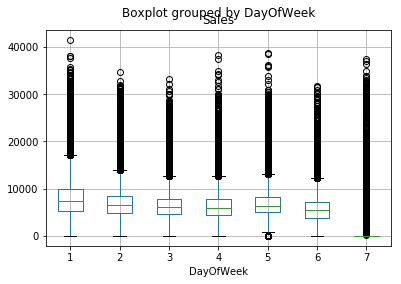

In [13]:
# analyse des ventes par jour de la semaine
df.boxplot(column="Sales", by="DayOfWeek" )
plt.show()

In [183]:
### on prend un store au hasard pour analyser les patterns
zz = df[df.Store==2].copy()
zz.sort_values("Date",inplace=True,axis=0)
zz.reset_index(inplace=True, drop=True)
print(zz.shape)
zz = zz[zz.Open==1]
print(zz.shape)

(942, 19)
(784, 19)


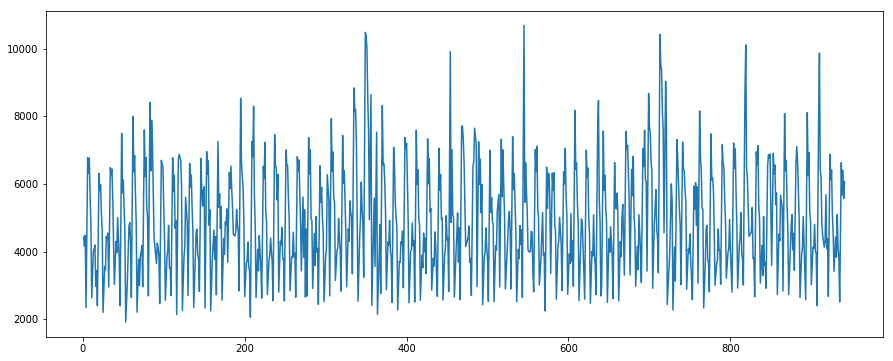

In [184]:
plt.figure(figsize=[15,6])
plt.plot(zz.Sales)
plt.show()

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


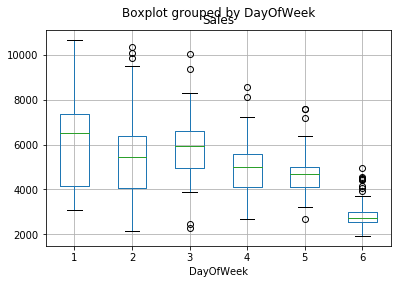

In [185]:
# observons par jour de la semaine
# il semble y avoir une tendance hebdomadaire évidente
zz.boxplot("Sales","DayOfWeek")
plt.show()

Pour y voir plus clair dans les valeurs anormales, on enleve la trend hebdomadaire. On prend la différence entre les ventes du jour et la valeur médiane du jour de la semaine correspondant, en valeur absolue.

In [199]:
def detrend_week(zz,day_eval=len(zz)):time
    zz.reset_index(inplace=True,drop=True)
    zz["sales_detrend_week"] = zz.Sales.values
    for i in zz.DayOfWeek.unique():
        med = zz.loc[(zz.DayOfWeek==i) & (zz.index<day_eval),"Sales"].median()
        zz.loc[zz.DayOfWeek==i,"sales_detrend_week"] = abs(zz.loc[zz.DayOfWeek==i,"Sales"].values - med)
    return zz["sales_detrend_week"].values

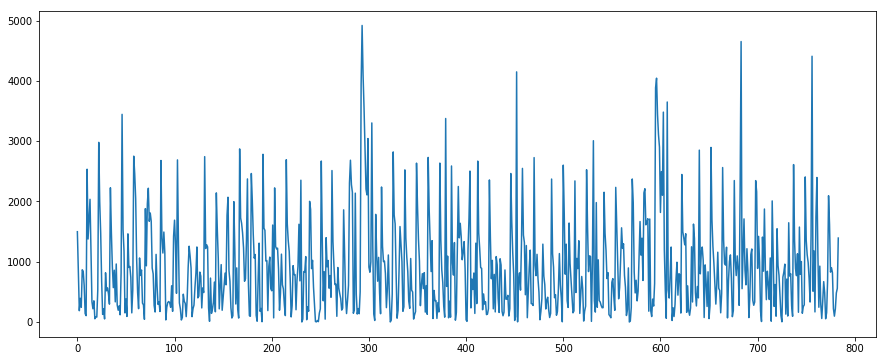

In [200]:
### sales detrend par jour de la semaine pour le même store
zz["sales_detrend_week"] = detrend_week(zz)
plt.figure(figsize=[15,6])
plt.plot(zz.sales_detrend_week)
plt.show()

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


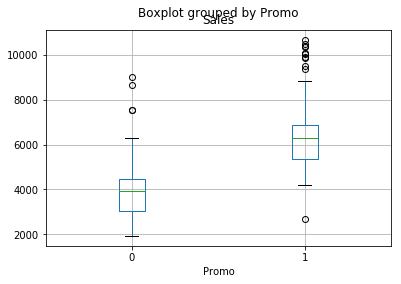

In [201]:
# Les ventes sont plus élevées en période de promo, avec plus de valeurs exrtêmes
# le modèle devrait prendre en compte cette différence
zz.boxplot("Sales","Promo")
plt.show()

## Détermination du seuil

On détermine un seuil qui nous permette de déterminer si les ventes sont anormales ou non. Le seuil doit idéalement séparer la partie "queue épaisse" de la partie "normale" de la distribution des ventes.

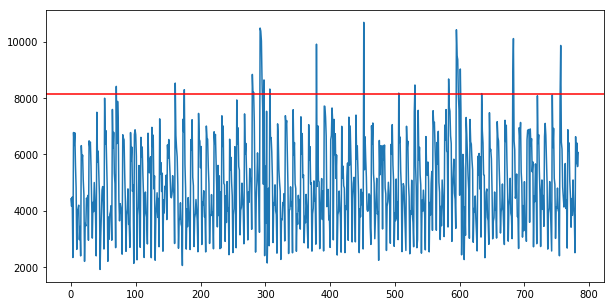

In [203]:
# on reprend l'exemple précédent
plt.figure(figsize=[10,5])

plt.plot(zz.Sales)
plt.axhline(np.percentile(zz.Sales.values,97), color="red")

plt.show()

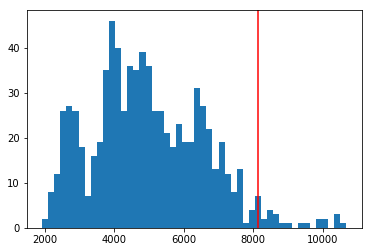

In [172]:
# observons la distribution des ventes
plt.hist(zz.Sales, bins=50)
plt.axvline(np.percentile(zz.Sales.values,97), color="red")
plt.show()

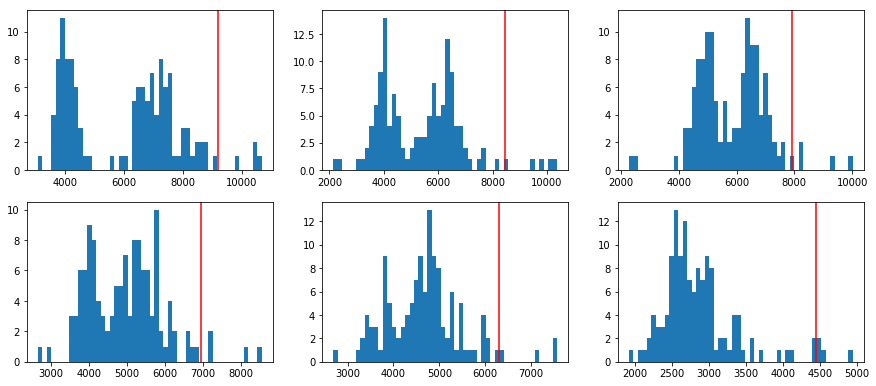

In [176]:
# par jour de la semaine
plt.figure(figsize=[15,10])

for i in range(1,7):
    plt.subplot(3,3,i)
    plt.hist(zz[zz.DayOfWeek==i].Sales, bins=50)
    plt.axvline(np.percentile(zz[zz.DayOfWeek==i].Sales.values,97), color="red")
plt.show()

A première vue, le quantile 97% semble être un bon candidat

## Détection des outliers

On définit une fonction d'alerting qui renvoie les indices des ventes anormales. La fonction évalue chaque jour de vente, en fonction des valeurs passées. On se base sur un historique de 6 mois et on teste sur le reste de la période.

La fonction compare les ventes d'un jour donné par rapport à la distribution d'un jour "équivalent". Pour cela, on retranche la trend hebdomadaire afin d'avoir des valeurs comparables pour chaque jour de la semaine. Ensuite, on évalue la valeur du jour par rapport à la distribution des ventes passées. On distingue également les périodes de
promotion et hors promotion.

In [204]:
def outlier_alert_promo(df_store, start_eval = 182, promo=True, thres_perc = 97):
    df_store.reset_index(inplace=True,drop=True)
    df_store["sales_detrend_week"] = detrend_week(df_store,start_eval) #enleve la trend hebdo
    outlier_index= []
    for day_index in range(start_eval,len(df_store)):
        is_promo = df_store.Promo.values[day_index]
        val = df_store["sales_detrend_week"].values[day_index] # ventes du jour considéré
        
        # on prend toutes les valeurs passées des 6 derniers mois correspondant au jour considéré (promo ou pas)
        val_past = abs( df_store.loc[(df_store.Promo==is_promo)&(df_store.index>day_index-180)&
                           (df_store.index<day_index),"sales_detrend_week"].values )
        if len(val_past)>0:
            thres = np.percentile(val_past, thres_perc ) # on situe le seuil à un certain niveau de quantile
        else:
            val_past = abs( df_store.loc[(df_store.index>day_index-180)&
                           (df_store.index<day_index),"sales_detrend_week"].values )
            thres = np.percentile(val_past, thres_perc )
            
        if val > thres: # on compare la valeur du jour par rapport au seuil
            outlier_index.append(day_index)
    return outlier_index


In [235]:
def plot_outlier(df,store):
    zz = df[df.Store==store].reset_index()
    outlier_index = outlier_alert_promo(zz, promo=True)
    plt.figure(figsize=[15,7])
    
    plt.subplot(2,1,1)
    plt.plot(zz.Sales, color="blue")
    plt.xlim(180,)
    plt.title("Ventes "+str(store))
    for i in outlier_index:
        plt.axvline(i,color="red", linewidth=0.5)
        
    plt.subplot(2,1,2)
    plt.plot( detrend_week(zz), color="blue")
    plt.xlim(180,)
    plt.title("Ventes no hebdo trend "+str(store))
    for i in outlier_index:
        plt.axvline(i,color="red", linewidth=0.5)
    plt.show()

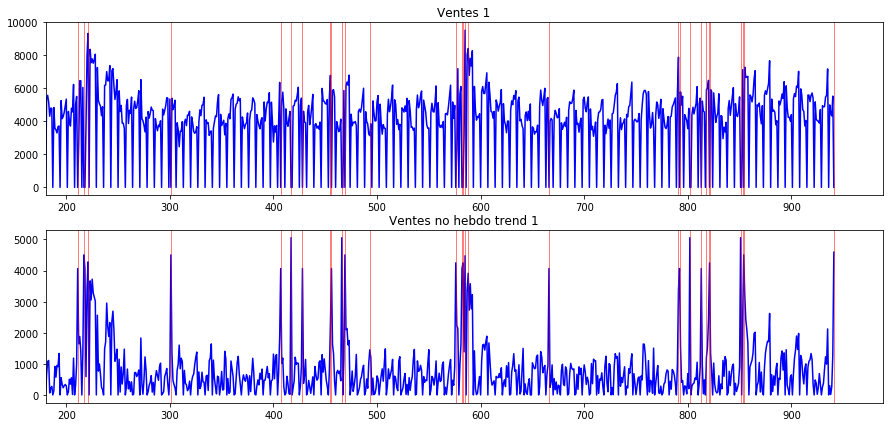

In [241]:
plot_outlier(df,1)

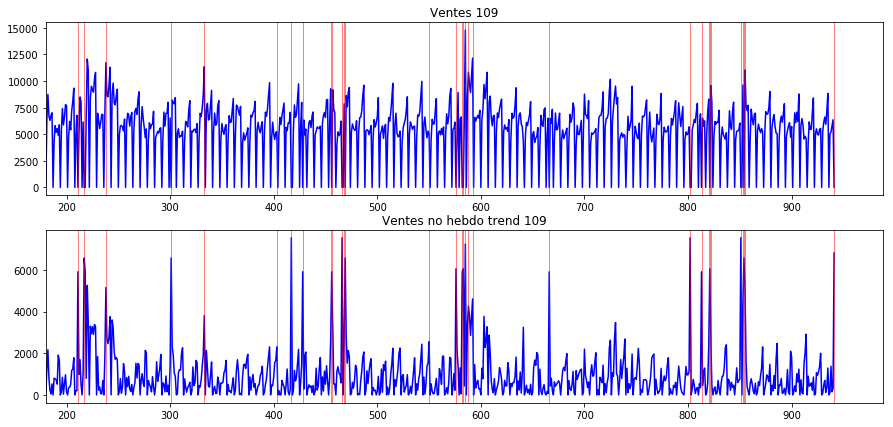

In [238]:
index = np.random.randint(1,len(df.Store.unique())-1,1)[0]
plot_outlier(df,index)

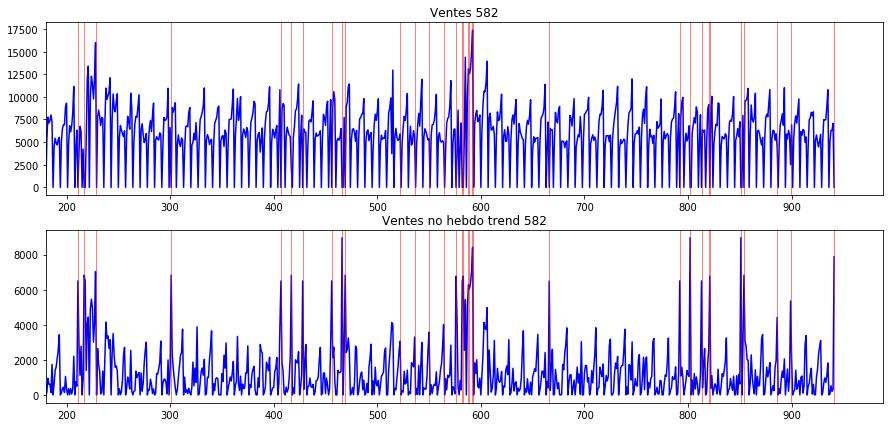

In [239]:
index = np.random.randint(1,len(df.Store.unique())-1,1)[0]
plot_outlier(df,index)

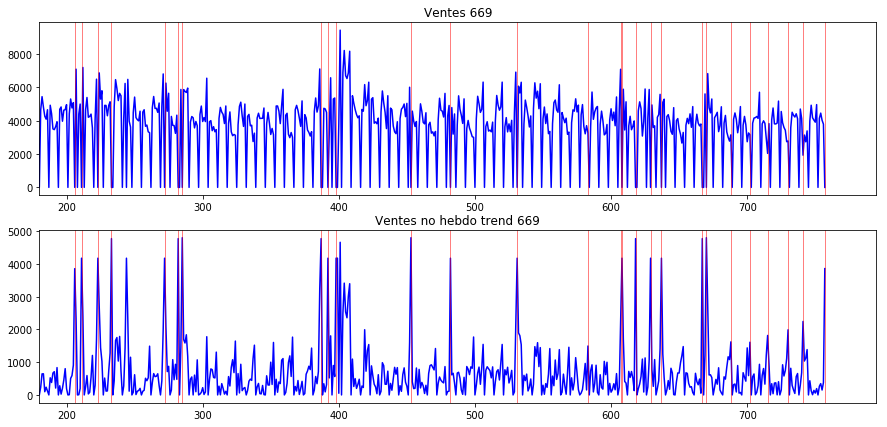

In [240]:
index = np.random.randint(1,len(df.Store.unique())-1,1)[0]
plot_outlier(df,index)

En regardant l'évolution des ventes sur l'ensemble de la période, il est difficile de distinguer si les alertes ont du sens ou non. Cependant, les ventes retranchées de leur valeur hebdomadaire médiane nous permettent de bien distinguer les valeurs normales des ventes aberrantes. Sur ces quelques exemples tirés aléatoirement, l'algorithme semble repérer la plupart des valeurs extrêmes. L'algorithme semble lèver également quelques fausses alertes.

## Pistes d'amélioration

Une analyse plus fine permettrait de trouver d'autres patterns permettant de mieux expliquer certaines valeurs aberrantes, notamment:
* Prendre en compte un éventuel pattern par type de store
* Analyse des périodes de vacances